In [1]:
import csv
import numpy as np
import pandas as pd
from matplotlib import gridspec
from matplotlib import pylab as plt
from mpl_toolkits.mplot3d import Axes3D

/home/surchs/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:1011: UserWarning: Duplicate key in file "/home/surchs/.config/matplotlib/matplotlibrc", line #405
  (fname, cnt))


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
def gen_window(win_range, box_number, start_age):
    """
    Generate a window for the uniform sampling
    """
    # And the divisions between the boxes
    window = np.zeros((2,box_number))
    # Generate the lower edges of the boxes
    window[0,:] = np.linspace(0, win_range, box_number, endpoint=False) + start_age
    window[1,:] = np.linspace(window[0,1], win_range+start_age, box_number)
    
    return window

In [4]:
def get_boxsubs(site, window):
    """
    Returns a vector of subject numbers
    corresponding to the boxes in window
    """
    # Get the number of boxes in the window
    box_number = window.shape[1]
    # Convert the site into an array
    site = np.array(site)
    # Compute the number of subjects in each box
    box_subs = [np.sum(np.logical_and(site>window[0,idx],site<=window[1,idx])) for idx in np.arange(box_number)]
    # Convert the number of box subs into an array
    box_subs = np.array(box_subs)
    
    return box_subs

In [5]:
def opt_sites(site_subs, uniform=True):
    """
    Find the optimal sites to maximize number 
    of subjects
    
    """
    # Get the number of sites
    site_number = site_subs.shape[0]
    box_number = site_subs.shape[1]
    # Get the smallest number per box
    min_subs = np.min(site_subs,1)
    # Sort the sites by subjects per box
    site_sort = np.argsort(min_subs)
    # Find the position of the last site with 
    # zero subjects
    last_zero = np.argwhere(min_subs[site_sort]==0)[-1]
    # Iteratively remove sites and see if 
    # the total number of subjects improves
    sub_vec = np.zeros((site_number,))
    for idx in np.arange(last_zero,site_number):
        # Slice the sites
        tmp_site_idx = site_sort[idx:]
        # See if we want the same number from all
        # sites or just within sites
        if uniform:
            # Get the number of remaining sites
            tmp_site_number = len(tmp_site_idx)
            # Get the minimal number of subjects
            tmp_min = np.min(site_subs[tmp_site_idx,:])
            # Get the total number of subjects
            tmp_total = tmp_min * tmp_site_number * box_number
        else:
            # We take the sum across all the sites
            # since we already dropped the ones with 
            # zero subjects
            tmp_sum = np.sum(np.min(site_subs[tmp_site_idx,:],1))
            # Get the total number of subjects
            tmp_total = tmp_sum * box_number
        sub_vec[idx] = tmp_total
    # Find the set of sites with the largest number
    # of subjects
    if np.max(sub_vec)==0:
        # None of the sites contribute, throw them all out
        max_idx = site_number
    else:
        max_idx = np.argmax(sub_vec)
    sites = site_sort[max_idx:]
            
    return sites

In [6]:
def opt_subjects(site_list, win_range, box_number, age_full, uniform=True, n_windows=40):
    """
    Optimizes the number of subjects across sites
    by generating and shifting a window of ages
    divided into boxes
    
    Returns:
        number of subjects
        optimal window
        list of sites
    """
    site_number = len(site_list)
    # Find the minimal and maximal age values
    age_min = np.min(age_full)
    age_max = np.max(age_full)
    age_range = age_max - age_min
    # Compute the window step
    win_shift = age_range - win_range
    win_step = win_shift / n_windows
    # Compute the starting ages for the windows
    start_ages = np.arange(0,win_shift+0.1, win_step) + age_min
    
    # Prepare a list for the results
    res_list = list()
    sub_vec = np.zeros((n_windows))
    # Iterate through the different windows and 
    # find the maximum number of subjects
    for win_id in np.arange(n_windows):
        start_age = start_ages[win_id]
        # Generate the window
        window = gen_window(win_range, box_number, start_age)
        # Iterate through sites and collect number 
        # of subjects per box for all of them
        site_subs = np.zeros((site_number, box_number))
        for s_id, site in enumerate(site_list):
            site_subs[s_id, :] = get_boxsubs(site, window)

        # Find the optimal sites for this window and box
        sites = opt_sites(site_subs, uniform)
        # Check if any sites are left
        if sites.size:
            # Check if uniform
            if uniform:
                # Compute the total number of subjects
                min_sub = np.min(site_subs[sites,:])
                total_subjects = min_sub * len(sites) * box_number
                # Set all sites to the minimal value
                n_subs = np.tile(min_sub,(len(sites),))
            else:
                # Take the sum of the minimal subjects numbers
                # at each site
                n_subs = np.min(site_subs[sites,:],1)
                sum_sub = np.sum(n_subs)
                total_subjects = sum_sub * box_number
        else:
            # There are no sites left
            min_sub = 0
            total_subjects = 0
            n_subs = 0
        sub_vec[win_id] = total_subjects
        res_list.append((total_subjects, sites, n_subs, site_subs, window))
    
    # Get the optimal number of subjects
    max_sub_id = np.argmax(sub_vec)
    best_result = res_list[max_sub_id]
    
    return best_result

In [7]:
def show_grid_results(boxes, windows, results, sites):
    """
    Hand over the grid search results and get an overview
    """
    # Prepare stuff
    x_ticks = np.round(np.linspace(0,len(boxes)-1,10))
    x_labels = np.array([boxes[ind] for ind in x_ticks])
    y_ticks = np.round(np.linspace(0,len(windows)-1,10))
    y_labels = np.array([windows[ind] for ind in y_ticks])
    a, b = results.T.shape
    X, Y = np.mgrid[:a, :b]
    N = sites/np.max(sites)

    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 
    # Make the subject overview
    ax1 = fig.add_subplot(gs[0,0], projection='3d')
    surf = ax1.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,
            linewidth=0, antialiased=False)
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_labels)
    ax1.set_xlabel('# of bins')
    ax1.set_ylabel('age range')
    ax1.set_zlabel('# of subjects')

    # Make the site overview
    ax = fig.add_subplot(gs[1,0], projection='3d')
    surf = ax.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,facecolors=cm.hot(N.T),
            linewidth=0, antialiased=True)
    colmap = cm.ScalarMappable(cmap=cm.hot)
    colmap.set_array(sites.T)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('# of bins')
    ax.set_ylabel('age range')
    ax.set_zlabel('# of subjects')
    ax.set_title('Number of sites for subject solutions')

    # Show the boxes over subjects
    ax3 = fig.add_subplot(gs[:,1])
    ax3.plot(np.max(results,0),boxes, label='#subjects')
    ax3.axvline(x=150, color='y', label='painful')
    ax3.axvline(x=100, color='r', label='unusable')
    ax3.set_ylim([np.min(boxes), np.max(boxes)])
    ax3.set_xlabel('# of subjects')
    ax3.set_ylabel('# of bins')
    ax3.legend()
    ax3.set_title('Age resolution vs number of subjects')
    plt.tight_layout()
    fig.suptitle('Different site contribution')

In [8]:
def find_sample(pheno, results, res_list, box_number):
    """
    Select a box number and get the corresponding 
    variables
    """
    # Get all the site names
    all_sites = pheno['SITE_ID'].unique()
    # Retrieve the box coordinate for the sample
    box_coord = np.argwhere(boxes==box_number).flatten()[0]
    # Retrieve the window coordinate for the sample
    win_coord = np.where(results[:, box_coord]==np.max(results[:, box_coord]))[0][0]
    # Make the full coordinates
    coord = (win_coord, box_coord)
    # Get the flat coordinates back
    flat_coord = np.ravel_multi_index(coord, results.shape)
    # Get the results
    res = res_list[flat_coord]
    # Get the window
    win = res[4]
    # Get the sites IDs
    site_ids = res[1]
    # Get the site names
    site_names = list(all_sites[site_ids])
    # Get the number of subjects
    n_sub = res[2]
    return site_names, n_sub, win

In [9]:
def get_sample(pheno, site_names, n_subs, window):
    """
    Generate a random draw from the selected site
    names with the specified window and n_subs in 
    each bin.
    
    pheno: pandas dataframe
    site_names: list of strings corresponding to sites
    n_subs : vector of length #sites with subjects per bin
    window: 2*X array where X is the the number of bins+1
    """
    # Prepare list to store the IDs in
    sub_ids = list()
    # Iterate through the sites
    for s_id, site in enumerate(site_names):
        # Get bin number for this site
        site_subs = n_subs[s_id]
        # Get slice of pheno for this site
        sphen = pheno.loc[pheno['SITE_ID']==site]
        # Iterate through the boxes of the window
        for b_id, box in enumerate(window.T):
            start = box[0]
            stop = box[1]
            # Get the indices of all subjects in this range
            range_ids = np.logical_and(sphen['AGE_AT_SCAN'].values>start, sphen['AGE_AT_SCAN'].values<=stop)
            # Get the corresponding subjects IDs
            range_subs = sphen['SUB_ID'].values[range_ids]
            # Make sure we have at least site_subs
            if len(range_subs) < site_subs:
                raise Exception('Fewer than {} subjects between {} and {} in site {}'.format(site_subs,
                                                                                            start,
                                                                                            stop,
                                                                                            site))
            # Draw a random subsample of the subjects IDs
            np.random.shuffle(range_subs)
            sel_indices = list(range_subs[:site_subs])
            sub_ids = sub_ids + sel_indices
    return sub_ids

In [10]:
def summarize_sample(pheno, indices, window, spacer=0.2, fsz=(10,5)):
    """
    Summarize the sample
    """
    # Get the pheno data for the reported indices
    sel_pheno = pheno[pheno['SUB_ID'].isin(indices)]
    ages = sel_pheno['AGE_AT_SCAN'].values
    # Group the pheno by site
    grouped = sel_pheno.groupby('SITE_ID')
    # Get the site names
    site_names = grouped.groups.keys()
    # Get a list of the ages in the sample by site
    age_list = [grouped.get_group(st)['AGE_AT_SCAN'].values for st in site_names]
    # Generate the bins from the window
    #bins = np.append(window[0,:], window[1,-1])
    # More interesting bins
    bins = np.linspace(np.min(ages), np.max(ages),20)
    # Plot the results
    gs = gridspec.GridSpec(2, 2, top=0.98, wspace=0.5, hspace=0.5, height_ratios=[1,1.5]) 
    f = plt.figure(figsize=fsz)
    
    ax1 = f.add_subplot(gs[0,0])
    ax1.hist(age_list, bins,stacked=True, normed = False, label=site_names)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1),
               fancybox=True, shadow=False, ncol=1, prop={'size':7})
    
    # Get the general sample
    # First get the subjects not in the sample
    nonsam = pheno[~pheno['SUB_ID'].isin(indices)]
    all_group = nonsam.groupby('SITE_ID')
    site_names_nosam = all_group.groups.keys()

    n_sites = len(site_names_nosam)
    # Generate the site index
    site_ind = np.arange(1,n_sites+1)
    ind_dict = dict()
    for s_id, site in enumerate(site_names_nosam):
        ind_dict[site] = site_ind[s_id]

    all_ages_nosam = [all_group.get_group(st)['AGE_AT_SCAN'].values for st in site_names_nosam]

    ax2 = f.add_subplot(gs[1,:])
    for idx, ages in enumerate(all_ages_nosam):
        site_name = site_names_nosam[idx]
        l_ages = len(ages)
        ind = np.ones((l_ages,))*ind_dict[site_name]
        jitter = (np.random.random(l_ages,)*2-1)*spacer
        ind += jitter
        tmp = ax2.plot(ind, ages, 'ko')
    # Kinda sketchy but what the hell
    tmp = ax2.plot(ind, ages, 'ko',label='not included')


    # Now add the guys that belong to the sample
    sam = pheno[pheno['SUB_ID'].isin(indices)]
    all_group = sam.groupby('SITE_ID')
    site_names_sam = all_group.groups.keys()
    all_ages_sam = [all_group.get_group(st)['AGE_AT_SCAN'].values for st in site_names_sam]

    for idx, ages in enumerate(all_ages_sam):
        site_name = site_names_sam[idx]
        l_ages = len(ages)
        ind = np.ones((l_ages,))*ind_dict[site_name]
        jitter = (np.random.random(l_ages,)*2-1)*spacer
        ind += jitter
        tmp = ax2.plot(ind, ages, 'ro')
    # Kinda sketchy but what the hell
    tmp = ax2.plot(ind, ages, 'ro', label='included')

    tmp = ax2.set_xticks(site_ind)
    tmp = ax2.set_xticklabels(site_names_nosam, rotation=70)
    tmp = ax2.legend(loc='upper left', bbox_to_anchor=(1, 1),
               fancybox=True, shadow=False, ncol=1)
    
    # Plot the violin plots too
    ax3 = f.add_subplot(gs[0,1])
    violin_ind = np.arange(1,len(site_names_sam)+1)
    ax3.violinplot(age_list, violin_ind)
    tmp = ax3.set_xticks(violin_ind)
    tmp = ax3.set_xticklabels(site_names_sam, rotation=70)

In [11]:
def full_sample_summary(pheno, results, res_list, box_number, seed=1, figsz=(10,5)):
    """
    Get the full summary
    """
    np.random.seed(seed)
    site_names, n_sub, window = find_sample(pheno, results, res_list, box_number)
    sub_ids = get_sample(pheno, site_names, n_sub, window)
    summarize_sample(pheno, sub_ids, window, fsz=figsz)
    return sub_ids

# Run a grid search over a set of parameters to find the optimal sample solution

In [46]:
# Set up the parameters
pheno_path = '/data1/abide/Pheno/existing_pheno.csv'
pheno = pd.read_csv(pheno_path)

age_full = pheno['AGE_AT_SCAN'].values
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]

windows = np.arange(1,30,0.5)
n_windows = len(windows)
boxes = np.arange(2,30)
n_boxes = len(boxes)

## First with a constrained sample
An constrained sample requires all sites included in the sample to contribute the same number of subjects to the final sample.

In [13]:
res_con = np.zeros((n_windows, n_boxes))
sit_con = np.zeros((n_windows, n_boxes))
resl_con = list()
iter_id = 0
for w_id, win_range in enumerate(windows):
    for b_id, box_number in enumerate(boxes):
        res = opt_subjects(site_list, win_range, box_number, age_full, True)
        resl_con.append(res)
        res_con[w_id, b_id] = res[0]
        sit_con[w_id, b_id] = len(res[1])

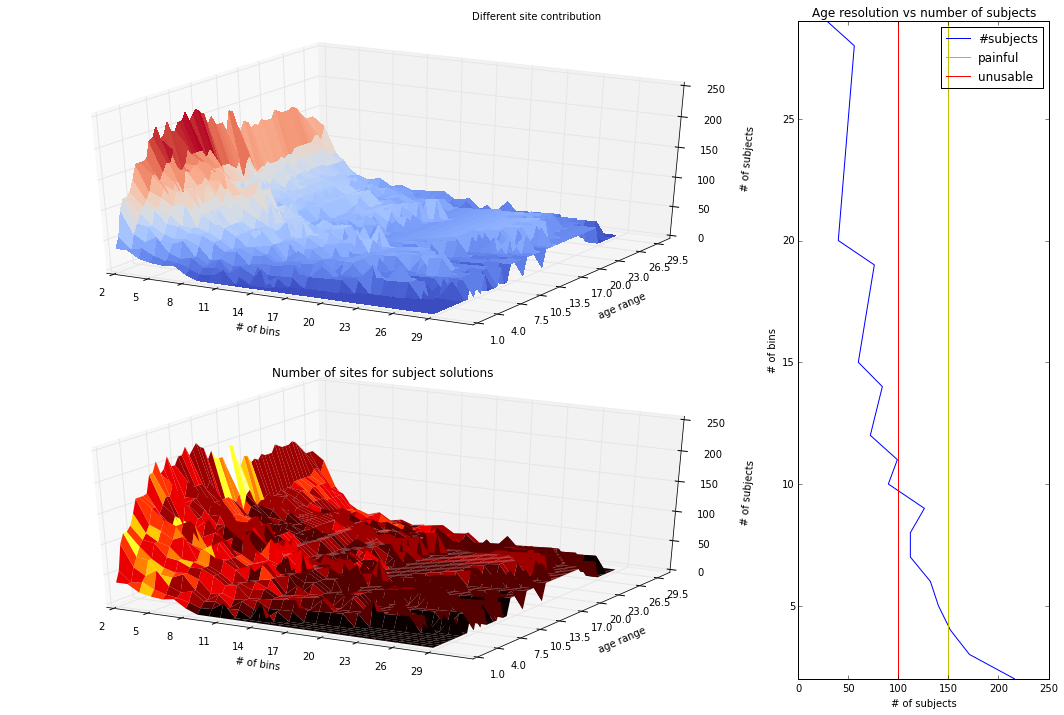

In [15]:
show_grid_results(boxes, windows, res_con, sit_con)

In [16]:
np.max(res_con)

216.0

152

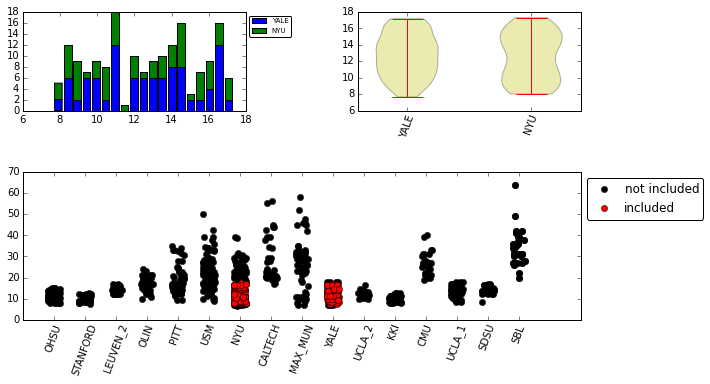

In [18]:
len(full_sample_summary(pheno, res_con, resl_con, 4))

## Now with an unconstrained sample
In an unconstrained sample, every included site can contribute as much as possible to maximize the total number of subjects. The distribution of subjects within a site still has to be uniform

In [47]:
res_unc = np.zeros((n_windows, n_boxes))
sit_unc = np.zeros((n_windows, n_boxes))
resl_unc = list()
iter_id = 0
for w_id, win_range in enumerate(windows):
    for b_id, box_number in enumerate(boxes):
        res = opt_subjects(site_list, win_range, box_number, age_full, False)
        resl_unc.append(res)
        res_unc[w_id, b_id] = res[0]
        sit_unc[w_id, b_id] = len(res[1])

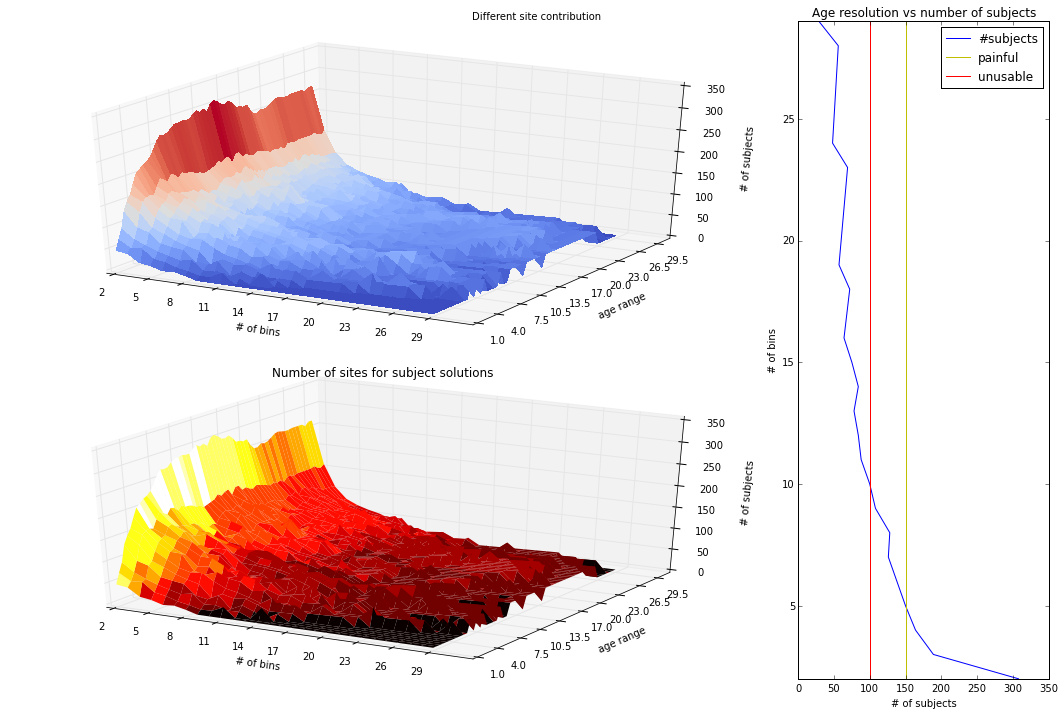

In [48]:
show_grid_results(boxes, windows, res_unc, sit_unc)

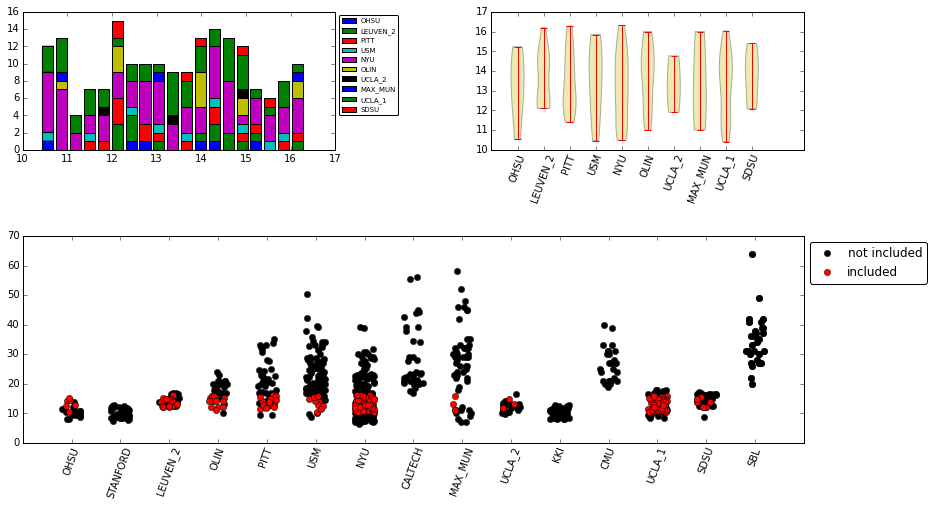

In [54]:
sub_ids = full_sample_summary(pheno, res_unc, resl_unc, 3,figsz=(14,7))

In [55]:
len(sub_ids)

189

In [56]:
sample_path = '/data1/abide/Pheno/unconstrained_3box_189_sample.csv'

In [57]:
# Turn this into a real sample
out_pheno = pheno.loc[pheno['SUB_ID'].isin(sub_ids)]
out_pheno.to_csv(sample_path, index=False)

In [30]:
# Deprecated
# with open(sample_path, 'w') as out_file:
#    wr = csv.writer(out_file)
#    wr.writerow(sub_ids)